In [1]:
import numpy as np
import pyclesperanto_prototype as cle
from skimage.io import imshow

import dask
import dask.array as da

cle.set_wait_for_kernel_finish(True)

computing 5 4 87


C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


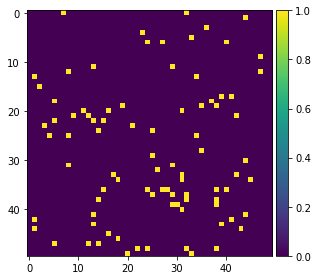

In [2]:
def data_generator(x=0, y=0, w=50, h=50):
    # pseudo-random point-pattern generation to have a reproducible dataset
    r = np.random.RandomState(x * y)
    coordinates = r.random((2, (x + 5) * (y + 5))) * np.asarray([[w],[h]])
    
    # create an image
    image = cle.create((h, w))
    # write at point coordinates
    cle.set(image, 0)
    cle.pointlist_to_labelled_spots(coordinates, image)
    
    # make binary image and retrieve from GPU
    result = cle.pull(image > 0)

    # for debugging; to see when the actual computation happens
    print("computing", x, y, np.sum(result))

    return result

example = data_generator(5, 4)

imshow(example)

In [3]:
def make_big_image(num_tiles_x=10, num_tiles_y=10, tile_width=50, tile_height=50):

    # we need to generate a single tile to know its shape and dtype
    example = data_generator()

    # setup the generator, which will be used many times to generate tiles
    delayed_generator = dask.delayed(data_generator)

    table = []
    for x in range(num_tiles_x):
        # set up a colum of tiles
        tiles = [delayed_generator(x, y, tile_width, tile_height) for y in range(num_tiles_y)]
        dask_tiles = [da.from_delayed(tile, shape=example.shape, dtype=example.dtype) for tile in tiles]
        column = da.concatenate(dask_tiles, axis=0)
        
        # collect column in a table
        table.append(column)

    # make a 2d tile dask array
    result = da.concatenate(table, axis=1)
    return result

big_image = make_big_image(num_tiles_x=50, num_tiles_y=50)
big_image

computing 0 0 25


dask.array<concatenate, shape=(2500, 2500), dtype=uint8, chunksize=(50, 50), chunktype=numpy.ndarray>

In [4]:
def process_image(image):
    print("blurring")
    return cle.pull(cle.gaussian_blur(image, sigma_x=1, sigma_y=2))

overlap_width = 5
processed_tiles = da.map_overlap(process_image, big_image, depth=overlap_width)
processed_tiles


C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\dask\array\overlap.py:642: FutureWarning: Default 'boundary' argument value will change from 'reflect' to 'none' in future versions from 2022.03.0 onwards. Use 'boundary="none"' to opt into the future behavior now or set 'boundary="reflect"' to maintain the current behavior going forward.
  warnings.warn(


blurring
blurring


dask.array<_trim, shape=(2500, 2500), dtype=float32, chunksize=(50, 50), chunktype=numpy.ndarray>

In [5]:
import napari
viewer = napari.Viewer()

viewer.add_image(example)

#viewer.add_image(big_image, cache=False, contrast_limits=[0, 1])

viewer.add_image(processed_tiles, cache=False, contrast_limits=[0, 1])

Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


computingcomputing 49 49 0 245
computing computing 48 1 297
 48 0 250
1 312
computingcomputing computing 49computing 48 2 353
 47 1 294
47 2 343
 0 250
computing 48 3 389
computing 47 2 339
computingcomputing 49 3 384
 47 3 384
computing 45 0 236
computingcomputing computing 4947 4 437
 4 439
 48 4 439
blurring
blurring
blurring
blurring
blurring
blurring
blurring
blurring
computingcomputingcomputing  46 2 335
 46 1 284
45 2 323
computing 43 0 233
computing 46 0 247
computing 45 1 285
computingcomputing 43 2 312
blurring
 44computing 0 238
 44computing 1 275
 43 1 269
blurring
computing 44 2 317
computing 41 0 222
computing computing 42 0 227
41 1 262
computing computing42 1 271
 41 2 305
blurring
blurring
blurring
blurringblurring

blurring
computingcomputing 39 0 214
 42 2 307
blurring
blurring
blurring
blurring
computing 39 1 251
computing 40 1 253
computing 40 2 303
computingcomputing 40 0 212
 37 0 199
computing 39 2 295
computing 38 0 208
computingcomputing 37 2 278
blurring
comp

<Image layer 'processed_tiles' at 0x21a5b121070>

In [6]:
viewer.add_image?

Signature:
viewer.add_image(
    data=None,
    *,
    channel_axis=None,
    rgb=None,
    colormap=None,
    contrast_limits=None,
    gamma=1,
    interpolation='nearest',
    rendering='mip',
    depiction='volume',
    iso_threshold=0.5,
    attenuation=0.05,
    name=None,
    metadata=None,
    scale=None,
    translate=None,
    rotate=None,
    shear=None,
    affine=None,
    opacity=1,
    blending=None,
    visible=True,
    multiscale=None,
    cache=True,
    plane=None,
    experimental_clipping_planes=None,
) -> 'Union[Image, List[Image]]'
Docstring:
Add an image layer to the layer list.

Parameters
----------
data : array or list of array
    Image data. Can be N >= 2 dimensional. If the last dimension has length
    3 or 4 can be interpreted as RGB or RGBA if rgb is `True`. If a
    list and arrays are decreasing in shape then the data is treated as
    a multiscale image. Please note multiscale rendering is only
    supported in 2D. In 3D, only the lowest resolution 

computingcomputingcomputing 3 0 39
 4 0 44 
computing0  0 25
computing1  0 30
7 0 60
computingcomputing 8 0 65
 computing computing2 0 35
9 11 0 80
 0 69
computing 5 0 50
computing 10 0 75
computing 12 0 83
computing 14 0 94
computing 13 0 89
computing 15 0 98
computing 6 0 52
computing 16 0 102
computingcomputingcomputing 19 0 116
 21 0 128
 20 0 123
computingcomputing 23 0 135
computingcomputing  26 0 150
17 0 110
computing computing 22computing 18 0 111
 0 131
25  0 computing 27 0 158
29 0 168
149
computingcomputing 31 0 173
 24 0 140
computing 28 0 156
computing 30 0 170
computing 32 0 179
computing 36 0 200
computing 33 0 187
computing 40 0 212
computingcomputing 35 0 197
 34 0 188
computing 43 0 233
computing 37 0 199
computing 38 0 208
computingcomputingcomputing 41 0 222
  computing45 0 236
42 0 227
computing  39 0 214
44 0 238
computing 47 0 250
computing 46 0 247
computing 48 0 250
computingcomputing 1 1 36
 3 1 47
computingcomputingcomputing 5 1 59
computing 8 1 78
computing

Low image data range; displaying image with stretched contrast.


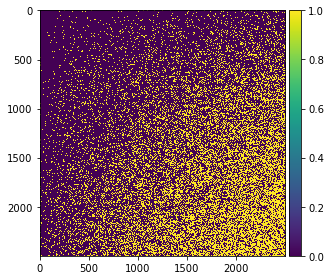

In [7]:
image = np.asarray(big_image)
print(np.sum(image))
imshow(image)